## Intro & Setup

In [1]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# general and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys

# outliers
from scipy.stats import zscore
from sklearn.neighbors import LocalOutlierFactor

# feature selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor

# modelling
import lightgbm as lgb
import optuna
import shap
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, median_absolute_error, r2_score 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.imputation import mice
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
diamonds = pd.read_csv('train.csv')
print(diamonds.shape)
diamonds.describe(include='all')

(193573, 11)


,id,carat,cut,color,clarity,depth,table,x,y,z,price
count,193573.000000,193573.000000,193573,193573,193573,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000
unique,NaN,NaN,5,7,8,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ideal,G,SI1,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,92454,44391,53272,NaN,NaN,NaN,NaN,NaN,NaN
mean,96786.000000,0.790688,NaN,NaN,NaN,61.820574,57.227675,5.715312,5.720094,3.534246,3969.155414
std,55879.856166,0.462688,NaN,NaN,NaN,1.081704,1.918844,1.109422,1.102333,0.688922,4034.374138
min,0.000000,0.200000,NaN,NaN,NaN,52.100000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,48393.000000,0.400000,NaN,NaN,NaN,61.300000,56.000000,4.700000,4.710000,2.900000,951.000000
50%,96786.000000,0.700000,NaN,NaN,NaN,61.900000,57.000000,5.700000,5.720000,3.530000,2401.000000
75%,145179.000000,1.030000,NaN,NaN,NaN,62.400000,58.000000,6.510000,6.510000,4.030000,5408.000000


In [4]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  object 
 3   color    193573 non-null  object 
 4   clarity  193573 non-null  object 
 5   depth    193573 non-null  float64
 6   table    193573 non-null  float64
 7   x        193573 non-null  float64
 8   y        193573 non-null  float64
 9   z        193573 non-null  float64
 10  price    193573 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 16.2+ MB


In [5]:
# encode the categorical variables
cut_dict = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_dict = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
colour_dict = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}

diamonds['cut'] = diamonds.cut.map(cut_dict)
diamonds['clarity'] = diamonds.clarity.map(clarity_dict)
diamonds['colour'] = diamonds.color.map(colour_dict)

diamonds['log_price'] = np.log(diamonds.price)
diamonds = diamonds[['carat', 'cut', 'clarity', 'colour', 'depth', 'table', 'x', 'y', 'z', 'price', 'log_price']]

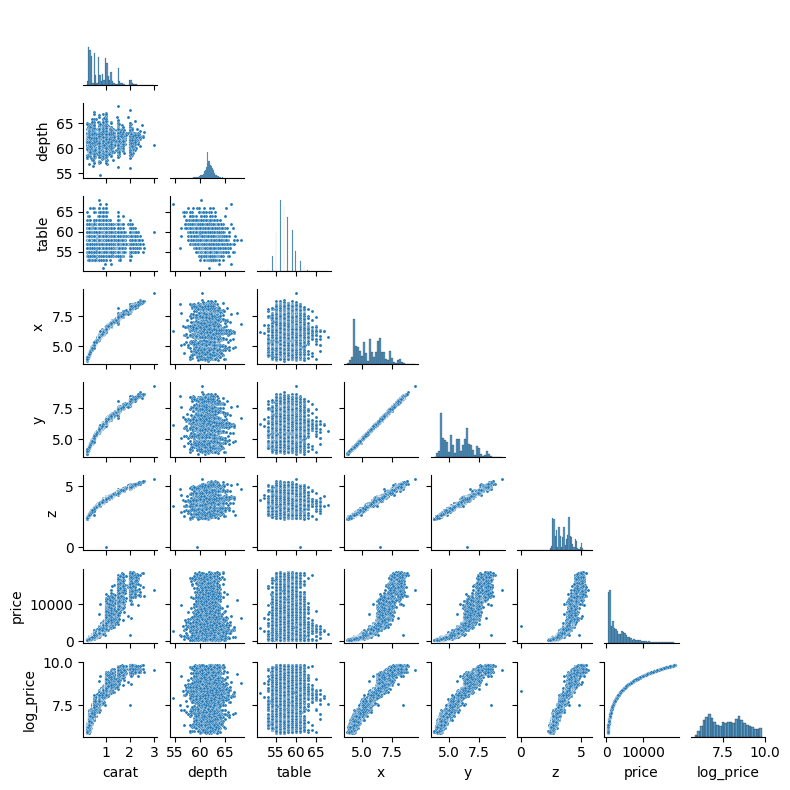

In [6]:
# 10,000 observations are sufficient to view the relationships
sns.pairplot(diamonds.loc[:10000, ['carat', 'depth', 'table', 'x', 'y', 'z', 'price', 'log_price']], corner=True, height=1,
             plot_kws=dict(s=5.0));

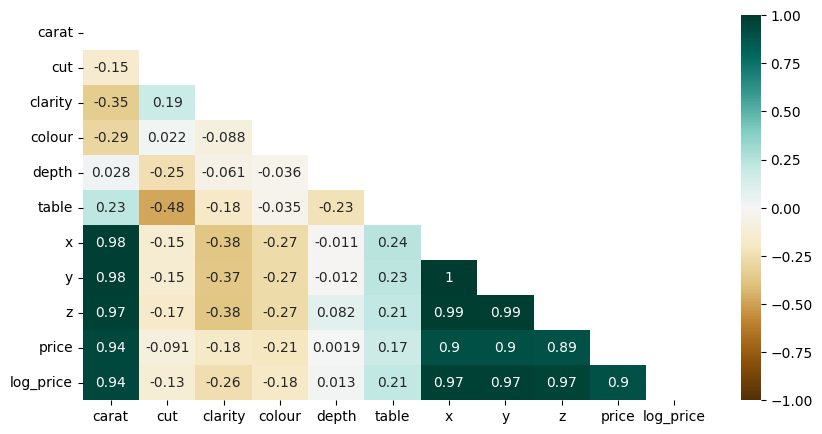

In [7]:
corr = diamonds.corr()
plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1, cmap='BrBG');

In [8]:
# confirm presence of multicollinearity
features = diamonds.drop(['log_price', 'price'], axis=1)

vif_scores = pd.DataFrame()
vif_scores['features'] = features.columns
vif_scores['VIF'] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]
vif_scores

,features,VIF
0,carat,100.226251
1,cut,13.300812
2,clarity,6.111574
3,colour,6.434996
4,depth,1023.698745
5,table,890.094723
6,x,16950.606518
7,y,15874.435631
8,z,1869.641876


## Baseline Model

In [9]:
def print_perf_metrics(y_true, y_pred, linear=True):
    if linear:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    else:
        y_true = y_true.copy()
        y_pred = y_pred.copy()
    
    print('RMSE: ', round(mean_squared_error(y_true, y_pred, squared=False), 4))
    print('R-squared: ', round(r2_score(y_true, y_pred), 4))
    print('MAE: ', round(mean_absolute_error(y_true, y_pred), 4))
    print('Median AE: ', round(median_absolute_error(y_true, y_pred), 4))
    print('MAPE: ', round(mean_absolute_percentage_error(y_true, y_pred) * 100, 4))
    print('-----')

In [10]:
# split data into train and validation sets
train, val = train_test_split(diamonds, test_size=0.2, random_state=23)
X_train = train.drop(['log_price', 'price'], axis=1)
y_train_linear = train.log_price
y_train_tree = train.price

X_val = val.drop(['log_price', 'price'], axis=1)
y_val_linear = val.log_price
y_val_tree = val.price

In [11]:
# fit the training data to a linear regression
base_linear_model = sm.OLS(y_train_linear, sm.add_constant(X_train)).fit()
# print(base_linear_model.summary())

# make predictions
train_preds = base_linear_model.predict(sm.add_constant(X_train))
val_preds = base_linear_model.predict(sm.add_constant(X_val))

# assess performance
print_perf_metrics(y_train_linear, train_preds)
print_perf_metrics(y_val_linear, val_preds)

RMSE:  831.7014
R-squared:  0.9574
MAE:  419.491
Median AE:  164.9309
MAPE:  10.5197
-----
RMSE:  817.9265
R-squared:  0.9592
MAE:  425.3184
Median AE:  168.3067
MAPE:  10.4672
-----


In [12]:
# fit the training data to a light gbm regressor
base_gb_model = lgb.LGBMRegressor()
base_gb_model.fit(X_train, y_train_tree)

# make predictions on the training and validation sets
train_preds = base_gb_model.predict(X_train)
val_preds = base_gb_model.predict(X_val)

# assess performance
print_perf_metrics(y_train_tree, train_preds, linear=False)
print_perf_metrics(y_val_tree, val_preds, linear=False)

RMSE:  554.999
R-squared:  0.981
MAE:  291.7081
Median AE:  124.8234
MAPE:  8.3614
-----
RMSE:  574.1257
R-squared:  0.9799
MAE:  297.6653
Median AE:  126.8656
MAPE:  8.3023
-----


## Imputed Missing Values

In [13]:
# # impute missing values using mice instead
# mice_data = mice.MICEData(diamonds)
# mice_data.conditional_formula['depth']
# mice_data.perturb_params('depth')
# mice_data.impute('depth')
# diamonds_imp = mice_data.data

# # split data into train and validation sets
# y = diamonds_imp.log_price
# X = diamonds_imp.drop('log_price', axis=1)

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [14]:
# # fit the training data to a linear regression
# imp_linear_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
# # print(imp_linear_model.summary())

# # make predictions
# train_preds = imp_linear_model.predict(sm.add_constant(X_train))
# val_preds = imp_linear_model.predict(sm.add_constant(X_val))

# # assess performance
# print_perf_metrics(y_train, train_preds)
# print_perf_metrics(y_val, val_preds)

In [15]:
# # fit the training data to a light gbm regressor
# imp_gb_model = lgb.LGBMRegressor()
# imp_gb_model.fit(X_train, y_train)

# # make predictions on the training and validation sets
# train_preds = imp_gb_model.predict(X_train)
# val_preds = imp_gb_model.predict(X_val)

# # assess performance
# print_perf_metrics(y_train, train_preds)
# print_perf_metrics(y_val, val_preds)

## Outliers Removed

In [16]:
# remove outliers using the z-score method - note that this assumes a normal/gaussian distribution
# # removes 726 observations
# z_score = np.abs(zscore(diamonds_imp))
# diamonds2 = diamonds_imp[(z_score < 3).all(axis=1)]

# remove outliers using a Local Outlier Factor score
# removes 7,694 observations from the training data only
lof = LocalOutlierFactor()
outlier_pred = lof.fit_predict(X_train)

mask = outlier_pred != -1
X_train2, y_train_linear2, y_train_tree2 = X_train.loc[mask, :], y_train_linear.loc[mask], y_train_tree.loc[mask]

In [17]:
# fit the training data to a linear regression
outlier_linear_model = sm.OLS(y_train_linear2, sm.add_constant(X_train2)).fit()
# print(outlier_linear_model.summary())

# make predictions
train_preds = outlier_linear_model.predict(sm.add_constant(X_train2))
val_preds = outlier_linear_model.predict(sm.add_constant(X_val))

# assess performance
print_perf_metrics(y_train_linear2, train_preds)
print_perf_metrics(y_val_linear, val_preds)

RMSE:  793.4912
R-squared:  0.9611
MAE:  413.8003
Median AE:  165.4678
MAPE:  10.3659
-----
RMSE:  804.541
R-squared:  0.9605
MAE:  421.1519
Median AE:  168.146
MAPE:  10.3987
-----


In [18]:
# fit the training data to a light gbm regressor
outlier_gb_model = lgb.LGBMRegressor()
outlier_gb_model.fit(X_train2, y_train_tree2)

# make predictions on the training and validation sets
train_preds = outlier_gb_model.predict(X_train2)
val_preds = outlier_gb_model.predict(X_val)

# assess performance
print_perf_metrics(y_train_tree2, train_preds, linear=False)
print_perf_metrics(y_val_tree, val_preds, linear=False)

RMSE:  555.3943
R-squared:  0.981
MAE:  292.3299
Median AE:  124.6414
MAPE:  8.2833
-----
RMSE:  575.1501
R-squared:  0.9798
MAE:  298.4562
Median AE:  126.4796
MAPE:  8.3166
-----


## Feature Selection

In [19]:
# apply feature selection
# # default scoring is r2
# # sklearn.metrics.get_scorer_names()
rfe = RFECV(estimator=DecisionTreeRegressor(), scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
# rfe = RFECV(estimator=DecisionTreeRegressor(), verbose=0, n_jobs=-1)
rfe.fit(X_train2, y_train_linear2)
for i, col in enumerate(X_train2.columns):
    print('Column: %s, Selected %s, Rank: %.3f' % (col, rfe.support_[i], rfe.ranking_[i]))
selected_features = rfe.get_feature_names_out(X_train2.columns)

X_train_sub = X_train2[selected_features]
# fit the training data
reduced_linear_model = sm.OLS(y_train_linear2, sm.add_constant(X_train_sub)).fit()
print('-----')
print(reduced_linear_model.summary())

# make predictions on the training and validation sets
X_val_sub = X_val[selected_features]
X_val_sub = sm.add_constant(X_val_sub)

train_preds = reduced_linear_model.predict(sm.add_constant(X_train_sub))
val_preds = reduced_linear_model.predict(X_val_sub)

# assess performance
print('-----')
print_perf_metrics(y_train_linear2, train_preds)
print_perf_metrics(y_val_linear, val_preds)

Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Column: carat, Selected True, Rank: 1.000
Column: cut, Selected False, Rank: 5.000
Column: clarity, Selected True, Rank: 1.000
Column: colour, Selected True, Rank: 1.000
Column: depth, Selected False, Rank: 2.000
Column: table, Selected False, Rank: 4.000
Column: x, Selected True, Rank: 1.000
Column: y, Selected True, Rank: 1.000
Column: z, Selected False, Rank: 3.000
-----
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.358e+06
Date:                Thu, 15 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:42:37   Log-Likelihood:                 72327.
No. Obser

## Hyperparameter Tuning

In [65]:
y = diamonds.price
X = diamonds.drop(['log_price', 'price'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [66]:
# https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
# https://forecastegy.com/posts/how-to-use-optuna-to-tune-lightgbm-hyperparameters/
def objective(trial):
    params = {
        "objective": 'root_mean_squared_error',
        "verbosity": -1,
        "bagging_freq": 1,
        "n_estimators": trial.suggest_categorical('n_estimators', range(300, 1000, 50)),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 3000), # the most important hyperparameter
        "max_depth": trial.suggest_int("max_depth", 3, 12), # the second most important hyperparameter
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize', study_name="LGBM Regressor")
# func = lambda trial: objective(trial, X_train, y_train)
study.optimize(objective, n_trials=30)

[I 2023-06-16 00:31:27,513] A new study created in memory with name: LGBM Regressor


[LightGBM] [Warning] min_data_in_leaf is set=5358, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:31:28,251] Trial 0 finished with value: 2036.5799306964743 and parameters: {'n_estimators': 300, 'learning_rate': 0.008012118691261009, 'num_leaves': 2735, 'max_depth': 8, 'subsample': 0.14447101726332656, 'colsample_bytree': 0.9083538669213531, 'min_data_in_leaf': 5358}. Best is trial 0 with value: 2036.5799306964743.


[LightGBM] [Warning] min_data_in_leaf is set=6380, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6380
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:31:31,683] Trial 1 finished with value: 964.9522716655239 and parameters: {'n_estimators': 800, 'learning_rate': 0.008722815729873322, 'num_leaves': 1340, 'max_depth': 4, 'subsample': 0.529201067423112, 'colsample_bytree': 0.8703386948889613, 'min_data_in_leaf': 6380}. Best is trial 1 with value: 964.9522716655239.


[LightGBM] [Warning] min_data_in_leaf is set=2317, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:31:35,974] Trial 2 finished with value: 1218.20048332485 and parameters: {'n_estimators': 800, 'learning_rate': 0.0022293804655256107, 'num_leaves': 1251, 'max_depth': 7, 'subsample': 0.27654834645510484, 'colsample_bytree': 0.9887063053572596, 'min_data_in_leaf': 2317}. Best is trial 1 with value: 964.9522716655239.


[LightGBM] [Warning] min_data_in_leaf is set=3584, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:31:37,960] Trial 3 finished with value: 624.0317803311657 and parameters: {'n_estimators': 450, 'learning_rate': 0.05677802605793388, 'num_leaves': 1413, 'max_depth': 3, 'subsample': 0.7483062605269918, 'colsample_bytree': 0.7769416790655844, 'min_data_in_leaf': 3584}. Best is trial 3 with value: 624.0317803311657.


[LightGBM] [Warning] min_data_in_leaf is set=398, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:31:42,780] Trial 4 finished with value: 751.7577834327764 and parameters: {'n_estimators': 800, 'learning_rate': 0.015579429692943706, 'num_leaves': 1046, 'max_depth': 6, 'subsample': 0.726691370028737, 'colsample_bytree': 0.21423995434327808, 'min_data_in_leaf': 398}. Best is trial 3 with value: 624.0317803311657.


[LightGBM] [Warning] min_data_in_leaf is set=7453, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:31:46,082] Trial 5 finished with value: 2352.3764843469276 and parameters: {'n_estimators': 550, 'learning_rate': 0.0011900667698913903, 'num_leaves': 1409, 'max_depth': 10, 'subsample': 0.9218128627787295, 'colsample_bytree': 0.47992347087003095, 'min_data_in_leaf': 7453}. Best is trial 3 with value: 624.0317803311657.


[LightGBM] [Warning] min_data_in_leaf is set=9589, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:31:47,249] Trial 6 finished with value: 2786.1568483899136 and parameters: {'n_estimators': 400, 'learning_rate': 0.0026576749132880763, 'num_leaves': 2032, 'max_depth': 6, 'subsample': 0.15469823949269917, 'colsample_bytree': 0.9062678186031051, 'min_data_in_leaf': 9589}. Best is trial 3 with value: 624.0317803311657.


[LightGBM] [Warning] min_data_in_leaf is set=4698, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:31:48,461] Trial 7 finished with value: 2598.063141178545 and parameters: {'n_estimators': 750, 'learning_rate': 0.0016208101402347712, 'num_leaves': 1256, 'max_depth': 4, 'subsample': 0.08774042059273504, 'colsample_bytree': 0.9133862732255701, 'min_data_in_leaf': 4698}. Best is trial 3 with value: 624.0317803311657.


[LightGBM] [Warning] min_data_in_leaf is set=3188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:31:51,780] Trial 8 finished with value: 995.1051783768269 and parameters: {'n_estimators': 750, 'learning_rate': 0.0032213816880269004, 'num_leaves': 2285, 'max_depth': 3, 'subsample': 0.5672064640421275, 'colsample_bytree': 0.5692725757131627, 'min_data_in_leaf': 3188}. Best is trial 3 with value: 624.0317803311657.


[LightGBM] [Warning] min_data_in_leaf is set=7078, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:31:55,365] Trial 9 finished with value: 1970.9351029987129 and parameters: {'n_estimators': 950, 'learning_rate': 0.04530299555867272, 'num_leaves': 2823, 'max_depth': 12, 'subsample': 0.1812123546844564, 'colsample_bytree': 0.3701693717780856, 'min_data_in_leaf': 7078}. Best is trial 3 with value: 624.0317803311657.


[LightGBM] [Warning] min_data_in_leaf is set=686, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:31:58,755] Trial 10 finished with value: 584.4661118245893 and parameters: {'n_estimators': 450, 'learning_rate': 0.09459892724744033, 'num_leaves': 71, 'max_depth': 9, 'subsample': 0.9507929597698042, 'colsample_bytree': 0.7005318337639428, 'min_data_in_leaf': 686}. Best is trial 10 with value: 584.4661118245893.


[LightGBM] [Warning] min_data_in_leaf is set=509, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=509
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:32:01,412] Trial 11 finished with value: 587.3973455001509 and parameters: {'n_estimators': 450, 'learning_rate': 0.07444901739636857, 'num_leaves': 7, 'max_depth': 9, 'subsample': 0.9849224565233804, 'colsample_bytree': 0.6889511268601118, 'min_data_in_leaf': 509}. Best is trial 10 with value: 584.4661118245893.


[LightGBM] [Warning] min_data_in_leaf is set=241, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=241
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:32:05,249] Trial 12 finished with value: 577.5681121951819 and parameters: {'n_estimators': 450, 'learning_rate': 0.08936374828855384, 'num_leaves': 65, 'max_depth': 10, 'subsample': 0.9945376037736102, 'colsample_bytree': 0.6896509863428757, 'min_data_in_leaf': 241}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=2069, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2069
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:32:10,178] Trial 13 finished with value: 586.2974334441624 and parameters: {'n_estimators': 650, 'learning_rate': 0.09964430039963112, 'num_leaves': 50, 'max_depth': 11, 'subsample': 0.8852866030110074, 'colsample_bytree': 0.6821839015222936, 'min_data_in_leaf': 2069}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=1547, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:32:15,754] Trial 14 finished with value: 589.6802928897959 and parameters: {'n_estimators': 450, 'learning_rate': 0.03586120725157401, 'num_leaves': 638, 'max_depth': 10, 'subsample': 0.997288826778714, 'colsample_bytree': 0.6059389546022056, 'min_data_in_leaf': 1547}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=218, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=218
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:32:22,896] Trial 15 finished with value: 583.560562209603 and parameters: {'n_estimators': 900, 'learning_rate': 0.09980658657934531, 'num_leaves': 466, 'max_depth': 9, 'subsample': 0.8217466819942167, 'colsample_bytree': 0.7396132524522685, 'min_data_in_leaf': 218}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=3066, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3066
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:32:29,783] Trial 16 finished with value: 595.0319957697977 and parameters: {'n_estimators': 900, 'learning_rate': 0.029401273706736227, 'num_leaves': 604, 'max_depth': 11, 'subsample': 0.8145038707789933, 'colsample_bytree': 0.7849787162730438, 'min_data_in_leaf': 3066}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=1610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1610
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:32:35,376] Trial 17 finished with value: 626.6950046236244 and parameters: {'n_estimators': 350, 'learning_rate': 0.02478490654148151, 'num_leaves': 538, 'max_depth': 12, 'subsample': 0.8431377136668947, 'colsample_bytree': 0.49046749948600477, 'min_data_in_leaf': 1610}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=4287, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:32:40,096] Trial 18 finished with value: 635.5552516602091 and parameters: {'n_estimators': 700, 'learning_rate': 0.059318833853676596, 'num_leaves': 412, 'max_depth': 8, 'subsample': 0.6732164254539023, 'colsample_bytree': 0.7889502875633327, 'min_data_in_leaf': 4287}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=1308, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1308
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:32:44,506] Trial 19 finished with value: 586.8510395071212 and parameters: {'n_estimators': 500, 'learning_rate': 0.05856909784374447, 'num_leaves': 791, 'max_depth': 9, 'subsample': 0.840072171205665, 'colsample_bytree': 0.6244948202005872, 'min_data_in_leaf': 1308}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=9022, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:32:46,363] Trial 20 finished with value: 1143.979793688074 and parameters: {'n_estimators': 600, 'learning_rate': 0.039460273843893064, 'num_leaves': 1795, 'max_depth': 7, 'subsample': 0.6324550003792025, 'colsample_bytree': 0.051345072321936025, 'min_data_in_leaf': 9022}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=202, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:32:53,587] Trial 21 finished with value: 580.7710982235343 and parameters: {'n_estimators': 900, 'learning_rate': 0.08828129670022836, 'num_leaves': 265, 'max_depth': 9, 'subsample': 0.9974360735961505, 'colsample_bytree': 0.7030594700596495, 'min_data_in_leaf': 202}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=313, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:33:00,805] Trial 22 finished with value: 581.2980104656228 and parameters: {'n_estimators': 900, 'learning_rate': 0.0996866587288691, 'num_leaves': 270, 'max_depth': 10, 'subsample': 0.9114117378042247, 'colsample_bytree': 0.7155007352966466, 'min_data_in_leaf': 313}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=2558, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2558
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:33:09,480] Trial 23 finished with value: 585.3943336134892 and parameters: {'n_estimators': 900, 'learning_rate': 0.0723604190817598, 'num_leaves': 245, 'max_depth': 10, 'subsample': 0.9934239983018559, 'colsample_bytree': 0.6287848705958883, 'min_data_in_leaf': 2558}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=1203, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1203
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:33:16,824] Trial 24 finished with value: 583.6578188893859 and parameters: {'n_estimators': 900, 'learning_rate': 0.04745211949993371, 'num_leaves': 275, 'max_depth': 11, 'subsample': 0.9052703896437242, 'colsample_bytree': 0.5338151342817424, 'min_data_in_leaf': 1203}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=1020, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1020
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:33:25,450] Trial 25 finished with value: 585.6661438815017 and parameters: {'n_estimators': 900, 'learning_rate': 0.02439585717908193, 'num_leaves': 881, 'max_depth': 11, 'subsample': 0.9120910208893154, 'colsample_bytree': 0.8353581134172268, 'min_data_in_leaf': 1020}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=1953, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:33:31,972] Trial 26 finished with value: 586.9023019557133 and parameters: {'n_estimators': 850, 'learning_rate': 0.07233308352729494, 'num_leaves': 939, 'max_depth': 10, 'subsample': 0.7770439935568483, 'colsample_bytree': 0.7068787893041323, 'min_data_in_leaf': 1953}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=3864, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:33:38,367] Trial 27 finished with value: 594.6526989637541 and parameters: {'n_estimators': 850, 'learning_rate': 0.03716006713339443, 'num_leaves': 311, 'max_depth': 8, 'subsample': 0.9993367744644155, 'colsample_bytree': 0.8277536577577496, 'min_data_in_leaf': 3864}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=2743, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:33:42,048] Trial 28 finished with value: 592.2469237733618 and parameters: {'n_estimators': 400, 'learning_rate': 0.07973718317478204, 'num_leaves': 220, 'max_depth': 12, 'subsample': 0.8840815738778156, 'colsample_bytree': 0.6587381464523755, 'min_data_in_leaf': 2743}. Best is trial 12 with value: 577.5681121951819.


[LightGBM] [Warning] min_data_in_leaf is set=5619, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:33:44,403] Trial 29 finished with value: 725.9771441056347 and parameters: {'n_estimators': 300, 'learning_rate': 0.017053249988220064, 'num_leaves': 2454, 'max_depth': 9, 'subsample': 0.9155560551076042, 'colsample_bytree': 0.7460117472818122, 'min_data_in_leaf': 5619}. Best is trial 12 with value: 577.5681121951819.


In [67]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 577.56811
	Best params:
		n_estimators: 450
		learning_rate: 0.08936374828855384
		num_leaves: 65
		max_depth: 10
		subsample: 0.9945376037736102
		colsample_bytree: 0.6896509863428757
		min_data_in_leaf: 241


In [68]:
best_params = study.best_trial.params

tuned_model = lgb.LGBMRegressor(**best_params, n_jobs=-1)
tuned_model.fit(X_train, y_train)

# make predictions
train_preds = tuned_model.predict(X_train)
val_preds = tuned_model.predict(X_val)

# assess performance
print_perf_metrics(y_train, train_preds, linear=False)
print_perf_metrics(y_val, val_preds, linear=False)

[LightGBM] [Warning] min_data_in_leaf is set=241, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=241
RMSE:  543.5197
R-squared:  0.9818
MAE:  282.1028
Median AE:  117.8895
MAPE:  7.8397
-----
RMSE:  578.3927
R-squared:  0.9796
MAE:  294.3338
Median AE:  121.4616
MAPE:  7.8841
-----


In [69]:
def objective(trial, X_train, y_train):
    params = {
        "objective": 'root_mean_squared_error',
        "verbosity": -1,
        "bagging_freq": 1,
        "n_estimators": trial.suggest_categorical('n_estimators', range(300, 1000, 50)),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 3000), # the most important hyperparameter
        "max_depth": trial.suggest_int("max_depth", 3, 12), # the second most important hyperparameter
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_val)
    rmse = mean_squared_error(y_val_tree, predictions, squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize', study_name="LGBM Regressor")
func = lambda trial: objective(trial, X_train2, y_train_tree2)
study.optimize(func, n_trials=30)

[I 2023-06-16 00:33:48,794] A new study created in memory with name: LGBM Regressor


[LightGBM] [Warning] min_data_in_leaf is set=8261, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:33:51,564] Trial 0 finished with value: 1156.704022292307 and parameters: {'n_estimators': 450, 'learning_rate': 0.07287040373576528, 'num_leaves': 1363, 'max_depth': 4, 'subsample': 0.4601254774398731, 'colsample_bytree': 0.6373831707580012, 'min_data_in_leaf': 8261}. Best is trial 0 with value: 1156.704022292307.


[LightGBM] [Warning] min_data_in_leaf is set=8167, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:33:53,774] Trial 1 finished with value: 1330.9567306369206 and parameters: {'n_estimators': 650, 'learning_rate': 0.054263916798873546, 'num_leaves': 2426, 'max_depth': 7, 'subsample': 0.39371130013969946, 'colsample_bytree': 0.3475829117977645, 'min_data_in_leaf': 8167}. Best is trial 0 with value: 1156.704022292307.


[LightGBM] [Warning] min_data_in_leaf is set=2165, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:33:55,997] Trial 2 finished with value: 1262.0135884845888 and parameters: {'n_estimators': 750, 'learning_rate': 0.010263438373175017, 'num_leaves': 120, 'max_depth': 11, 'subsample': 0.11313603940829242, 'colsample_bytree': 0.9253747499385517, 'min_data_in_leaf': 2165}. Best is trial 0 with value: 1156.704022292307.


[LightGBM] [Warning] min_data_in_leaf is set=6850, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6850
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:33:58,073] Trial 3 finished with value: 2099.1926666933396 and parameters: {'n_estimators': 800, 'learning_rate': 0.023725144276028096, 'num_leaves': 515, 'max_depth': 5, 'subsample': 0.15566205518406, 'colsample_bytree': 0.7995535823178495, 'min_data_in_leaf': 6850}. Best is trial 0 with value: 1156.704022292307.


[LightGBM] [Warning] min_data_in_leaf is set=4308, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4308
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:33:59,563] Trial 4 finished with value: 1122.3248534947659 and parameters: {'n_estimators': 500, 'learning_rate': 0.06936224364515226, 'num_leaves': 1320, 'max_depth': 5, 'subsample': 0.25575498999110496, 'colsample_bytree': 0.32616438015480953, 'min_data_in_leaf': 4308}. Best is trial 4 with value: 1122.3248534947659.


[LightGBM] [Warning] min_data_in_leaf is set=5538, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5538
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:34:04,977] Trial 5 finished with value: 1013.447084764464 and parameters: {'n_estimators': 900, 'learning_rate': 0.007904169589024618, 'num_leaves': 2456, 'max_depth': 11, 'subsample': 0.43099804471922637, 'colsample_bytree': 0.5091240416646087, 'min_data_in_leaf': 5538}. Best is trial 5 with value: 1013.447084764464.


[LightGBM] [Warning] min_data_in_leaf is set=9084, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:34:06,167] Trial 6 finished with value: 1671.966233217586 and parameters: {'n_estimators': 300, 'learning_rate': 0.008504688525491133, 'num_leaves': 628, 'max_depth': 8, 'subsample': 0.367602315124187, 'colsample_bytree': 0.536643834031982, 'min_data_in_leaf': 9084}. Best is trial 5 with value: 1013.447084764464.


[LightGBM] [Warning] min_data_in_leaf is set=2149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:34:09,148] Trial 7 finished with value: 2951.908599829335 and parameters: {'n_estimators': 800, 'learning_rate': 0.0010582483390369163, 'num_leaves': 2444, 'max_depth': 6, 'subsample': 0.5478320787043603, 'colsample_bytree': 0.13519655839307113, 'min_data_in_leaf': 2149}. Best is trial 5 with value: 1013.447084764464.


[LightGBM] [Warning] min_data_in_leaf is set=5167, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:34:13,366] Trial 8 finished with value: 1530.6004480519337 and parameters: {'n_estimators': 750, 'learning_rate': 0.0016691855083764055, 'num_leaves': 2174, 'max_depth': 5, 'subsample': 0.705471160287953, 'colsample_bytree': 0.98214643193344, 'min_data_in_leaf': 5167}. Best is trial 5 with value: 1013.447084764464.


[LightGBM] [Warning] min_data_in_leaf is set=1696, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:34:15,062] Trial 9 finished with value: 1571.5348744315895 and parameters: {'n_estimators': 600, 'learning_rate': 0.010327644955235582, 'num_leaves': 1767, 'max_depth': 6, 'subsample': 0.06705074538718363, 'colsample_bytree': 0.7955300059709206, 'min_data_in_leaf': 1696}. Best is trial 5 with value: 1013.447084764464.


[LightGBM] [Warning] min_data_in_leaf is set=4311, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4311
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:34:19,074] Trial 10 finished with value: 1633.1127141533402 and parameters: {'n_estimators': 900, 'learning_rate': 0.0033245509505151895, 'num_leaves': 2836, 'max_depth': 12, 'subsample': 0.9842804455687542, 'colsample_bytree': 0.06647778025405876, 'min_data_in_leaf': 4311}. Best is trial 5 with value: 1013.447084764464.


[LightGBM] [Warning] min_data_in_leaf is set=4903, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:34:21,105] Trial 11 finished with value: 1197.6831161394537 and parameters: {'n_estimators': 500, 'learning_rate': 0.09974509041129025, 'num_leaves': 1340, 'max_depth': 9, 'subsample': 0.2634753514788263, 'colsample_bytree': 0.3550424346270849, 'min_data_in_leaf': 4903}. Best is trial 5 with value: 1013.447084764464.


[LightGBM] [Warning] min_data_in_leaf is set=3705, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3705
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:34:22,097] Trial 12 finished with value: 1257.7186558678252 and parameters: {'n_estimators': 350, 'learning_rate': 0.027191384888784732, 'num_leaves': 1809, 'max_depth': 3, 'subsample': 0.19786980824859737, 'colsample_bytree': 0.3867373571104882, 'min_data_in_leaf': 3705}. Best is trial 5 with value: 1013.447084764464.


[LightGBM] [Warning] min_data_in_leaf is set=6294, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:34:23,573] Trial 13 finished with value: 1518.8666290608826 and parameters: {'n_estimators': 400, 'learning_rate': 0.03628777543783022, 'num_leaves': 992, 'max_depth': 10, 'subsample': 0.2654080076094314, 'colsample_bytree': 0.22919071257793605, 'min_data_in_leaf': 6294}. Best is trial 5 with value: 1013.447084764464.


[LightGBM] [Warning] min_data_in_leaf is set=3461, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3461
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:34:26,362] Trial 14 finished with value: 733.0119046766004 and parameters: {'n_estimators': 500, 'learning_rate': 0.016595870526263476, 'num_leaves': 1926, 'max_depth': 9, 'subsample': 0.5951237386905625, 'colsample_bytree': 0.49754472500976615, 'min_data_in_leaf': 3461}. Best is trial 14 with value: 733.0119046766004.


[LightGBM] [Warning] min_data_in_leaf is set=759, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=759
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:34:34,465] Trial 15 finished with value: 591.754692392983 and parameters: {'n_estimators': 700, 'learning_rate': 0.01656238563800665, 'num_leaves': 2936, 'max_depth': 12, 'subsample': 0.5861800850990317, 'colsample_bytree': 0.5175470983665003, 'min_data_in_leaf': 759}. Best is trial 15 with value: 591.754692392983.


[LightGBM] [Warning] min_data_in_leaf is set=201, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=201
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:34:48,181] Trial 16 finished with value: 581.8609644596069 and parameters: {'n_estimators': 700, 'learning_rate': 0.018707915205378824, 'num_leaves': 2968, 'max_depth': 12, 'subsample': 0.6127647838955468, 'colsample_bytree': 0.5248649910349452, 'min_data_in_leaf': 201}. Best is trial 16 with value: 581.8609644596069.


[LightGBM] [Warning] min_data_in_leaf is set=349, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:34:59,508] Trial 17 finished with value: 583.060161634813 and parameters: {'n_estimators': 700, 'learning_rate': 0.018525184029079773, 'num_leaves': 2887, 'max_depth': 12, 'subsample': 0.6872807222210283, 'colsample_bytree': 0.6520006939047316, 'min_data_in_leaf': 349}. Best is trial 16 with value: 581.8609644596069.


[LightGBM] [Warning] min_data_in_leaf is set=338, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:35:08,368] Trial 18 finished with value: 584.8824417870642 and parameters: {'n_estimators': 700, 'learning_rate': 0.04068958745060754, 'num_leaves': 2760, 'max_depth': 11, 'subsample': 0.7306348807496229, 'colsample_bytree': 0.6473527015211545, 'min_data_in_leaf': 338}. Best is trial 16 with value: 581.8609644596069.


[LightGBM] [Warning] min_data_in_leaf is set=1215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:35:16,496] Trial 19 finished with value: 591.1571984032361 and parameters: {'n_estimators': 850, 'learning_rate': 0.020010533247594747, 'num_leaves': 2538, 'max_depth': 10, 'subsample': 0.7041597273492742, 'colsample_bytree': 0.6460387684917089, 'min_data_in_leaf': 1215}. Best is trial 16 with value: 581.8609644596069.


[LightGBM] [Warning] min_data_in_leaf is set=3032, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:35:22,495] Trial 20 finished with value: 732.4311490916012 and parameters: {'n_estimators': 700, 'learning_rate': 0.005048429393115242, 'num_leaves': 2231, 'max_depth': 12, 'subsample': 0.8129116307441953, 'colsample_bytree': 0.7864826148645396, 'min_data_in_leaf': 3032}. Best is trial 16 with value: 581.8609644596069.


[LightGBM] [Warning] min_data_in_leaf is set=223, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=223
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:35:31,592] Trial 21 finished with value: 584.9598278866454 and parameters: {'n_estimators': 700, 'learning_rate': 0.04076399532866516, 'num_leaves': 2747, 'max_depth': 11, 'subsample': 0.6797200767791208, 'colsample_bytree': 0.6458820492537992, 'min_data_in_leaf': 223}. Best is trial 16 with value: 581.8609644596069.


[LightGBM] [Warning] min_data_in_leaf is set=608, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:35:38,183] Trial 22 finished with value: 584.692841769279 and parameters: {'n_estimators': 700, 'learning_rate': 0.03746214354245651, 'num_leaves': 2967, 'max_depth': 10, 'subsample': 0.797469337813695, 'colsample_bytree': 0.7115664526552331, 'min_data_in_leaf': 608}. Best is trial 16 with value: 581.8609644596069.


[LightGBM] [Warning] min_data_in_leaf is set=1444, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:35:46,299] Trial 23 finished with value: 588.1393007360831 and parameters: {'n_estimators': 950, 'learning_rate': 0.029149587357785615, 'num_leaves': 2993, 'max_depth': 10, 'subsample': 0.8694636923144141, 'colsample_bytree': 0.7293963814584828, 'min_data_in_leaf': 1444}. Best is trial 16 with value: 581.8609644596069.


[LightGBM] [Warning] min_data_in_leaf is set=2576, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:35:51,367] Trial 24 finished with value: 639.3965503745245 and parameters: {'n_estimators': 550, 'learning_rate': 0.01539168527824631, 'num_leaves': 2670, 'max_depth': 12, 'subsample': 0.6218804455887741, 'colsample_bytree': 0.5821024215626479, 'min_data_in_leaf': 2576}. Best is trial 16 with value: 581.8609644596069.


[LightGBM] [Warning] min_data_in_leaf is set=1230, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1230
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:35:58,066] Trial 25 finished with value: 597.1217515296124 and parameters: {'n_estimators': 700, 'learning_rate': 0.025751792333707703, 'num_leaves': 2199, 'max_depth': 9, 'subsample': 0.7879760229884587, 'colsample_bytree': 0.440060771838369, 'min_data_in_leaf': 1230}. Best is trial 16 with value: 581.8609644596069.


[LightGBM] [Warning] min_data_in_leaf is set=627, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:36:05,268] Trial 26 finished with value: 591.59752788155 and parameters: {'n_estimators': 700, 'learning_rate': 0.013628754547692483, 'num_leaves': 2637, 'max_depth': 10, 'subsample': 0.5013473874667802, 'colsample_bytree': 0.7399359251865789, 'min_data_in_leaf': 627}. Best is trial 16 with value: 581.8609644596069.


[LightGBM] [Warning] min_data_in_leaf is set=1845, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:36:11,374] Trial 27 finished with value: 619.1494605212434 and parameters: {'n_estimators': 700, 'learning_rate': 0.020864512193615417, 'num_leaves': 2987, 'max_depth': 12, 'subsample': 0.6541947172834062, 'colsample_bytree': 0.436339871194446, 'min_data_in_leaf': 1845}. Best is trial 16 with value: 581.8609644596069.


[LightGBM] [Warning] min_data_in_leaf is set=2809, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:36:15,281] Trial 28 finished with value: 615.2857730539154 and parameters: {'n_estimators': 600, 'learning_rate': 0.03357768771562266, 'num_leaves': 2179, 'max_depth': 11, 'subsample': 0.559568653449893, 'colsample_bytree': 0.5711617303341302, 'min_data_in_leaf': 2809}. Best is trial 16 with value: 581.8609644596069.


[LightGBM] [Warning] min_data_in_leaf is set=923, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=923
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-16 00:36:18,664] Trial 29 finished with value: 590.9537012373243 and parameters: {'n_estimators': 450, 'learning_rate': 0.06281092741187544, 'num_leaves': 1607, 'max_depth': 8, 'subsample': 0.4902671447320115, 'colsample_bytree': 0.6049358375443725, 'min_data_in_leaf': 923}. Best is trial 16 with value: 581.8609644596069.


In [70]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 581.86096
	Best params:
		n_estimators: 700
		learning_rate: 0.018707915205378824
		num_leaves: 2968
		max_depth: 12
		subsample: 0.6127647838955468
		colsample_bytree: 0.5248649910349452
		min_data_in_leaf: 201


In [71]:
best_params = study.best_trial.params

tuned_model2 = lgb.LGBMRegressor(**best_params, n_jobs=-1)
tuned_model2.fit(X_train2, y_train_tree2)

# make predictions
train_preds = tuned_model2.predict(X_train2)
val_preds = tuned_model2.predict(X_val)

# assess performance
print_perf_metrics(y_train_tree2, train_preds, linear=False)
print_perf_metrics(y_val_tree, val_preds, linear=False)

[LightGBM] [Warning] min_data_in_leaf is set=201, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=201
RMSE:  543.9718
R-squared:  0.9817
MAE:  278.2848
Median AE:  113.0745
MAPE:  7.4327
-----
RMSE:  582.6344
R-squared:  0.9793
MAE:  293.9106
Median AE:  117.9545
MAPE:  7.7141
-----


## Feature Importance

In [27]:
# # produces the same results as statsmodels but shap requires a scikit-learn object
# outlier_linear_model2 = LinearRegression()
# outlier_linear_model2.fit(X_train2, y_train_linear2)

# linear_explainer = shap.explainers.Linear(outlier_linear_model2, X_train2)
# linear_shap_vals = linear_explainer(X_train2)

# # visualise explaination over all observations
# shap.plots.force(base_value=linear_explainer.expected_value, shap_values=linear_shap_vals.values[:1000, :], features=X_train2.iloc[:1000, :])

# shap.plots.beeswarm(linear_shap_vals)
# # shap.summary_plot(linear_shap_vals, X_train2)

# # for col in X_train2.columns:
# #     shap.dependence_plot(col, linear_shap_vals[1], X_train2)

In [72]:
X_vals = X_train2[:10000]

lgb_explainer = shap.TreeExplainer(tuned_model2, X_vals)
lgb_shap_vals = lgb_explainer(X_vals)

100%|===================| 9992/10000 [12:17<00:00]        

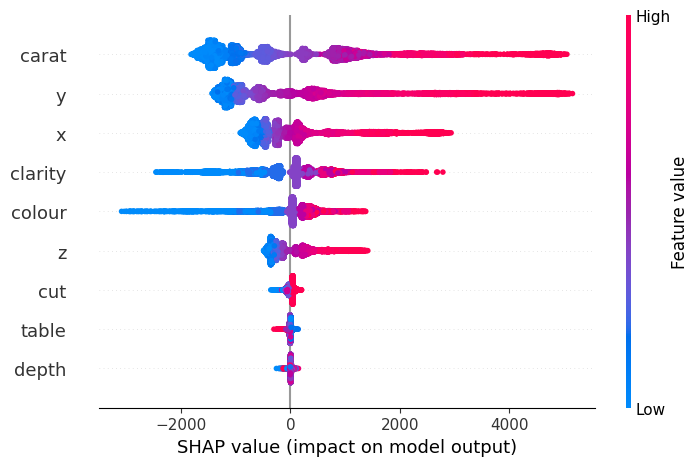

In [73]:
shap.plots.beeswarm(lgb_shap_vals)

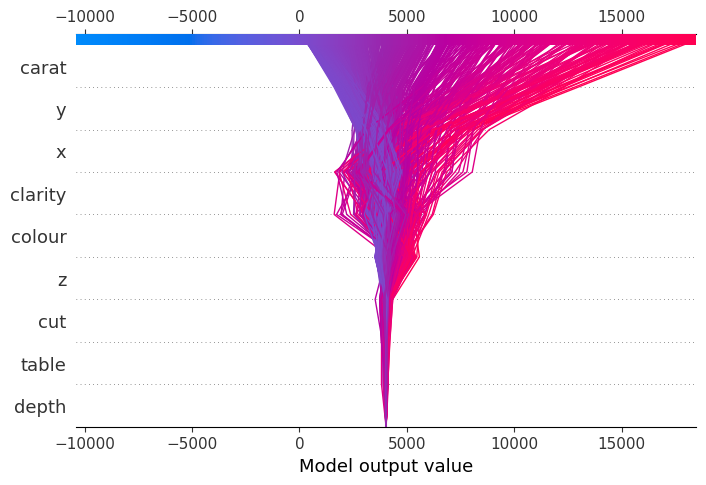

In [74]:
# decision plot for the first 1000 predictions
shap.decision_plot(lgb_explainer.expected_value, lgb_shap_vals.values[:1000], feature_names=list(X_vals.columns))

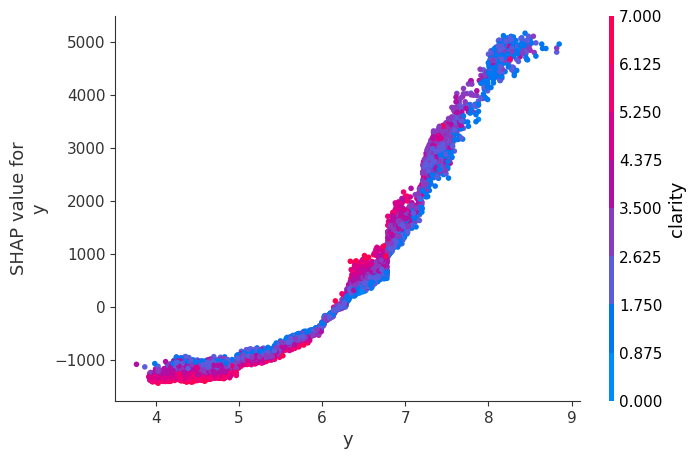

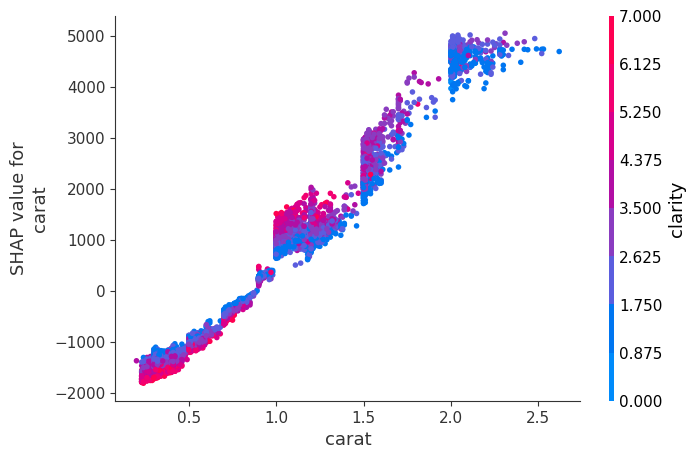

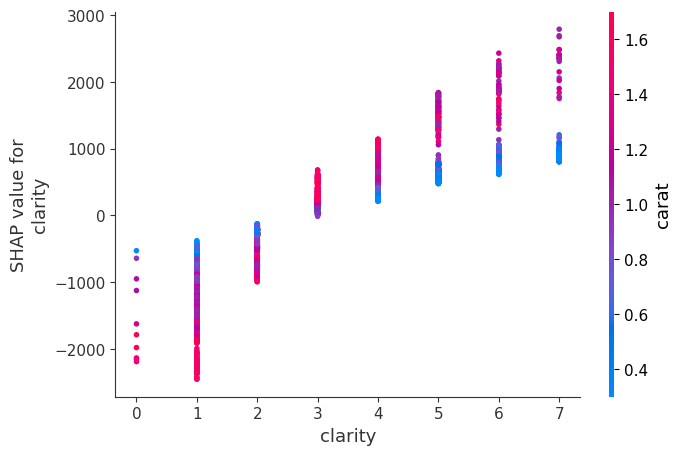

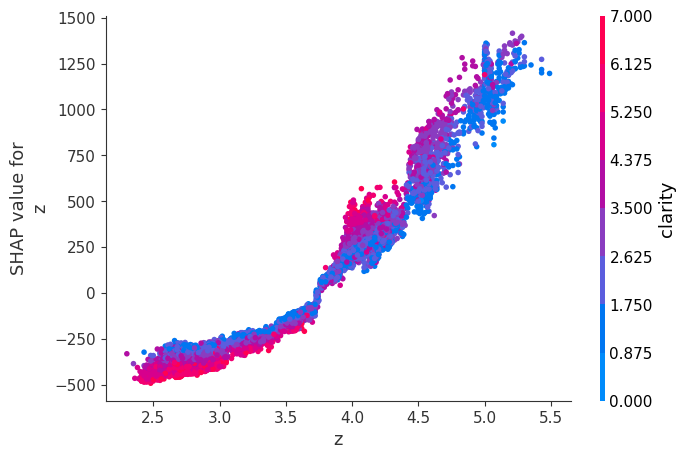

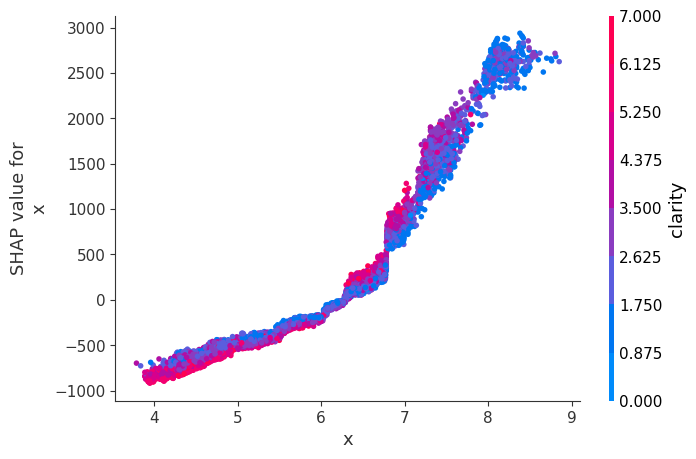

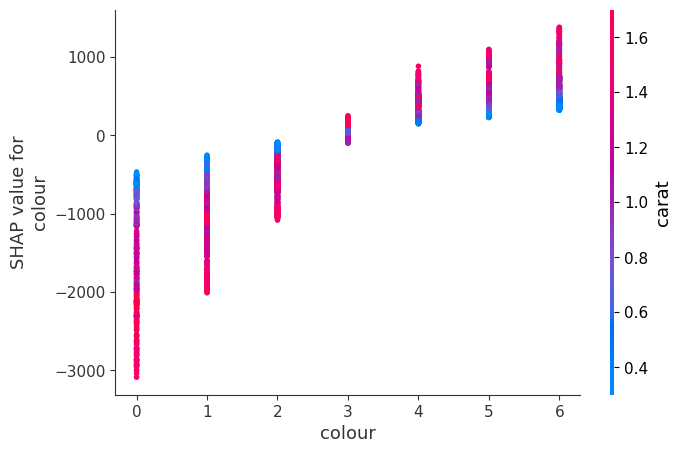

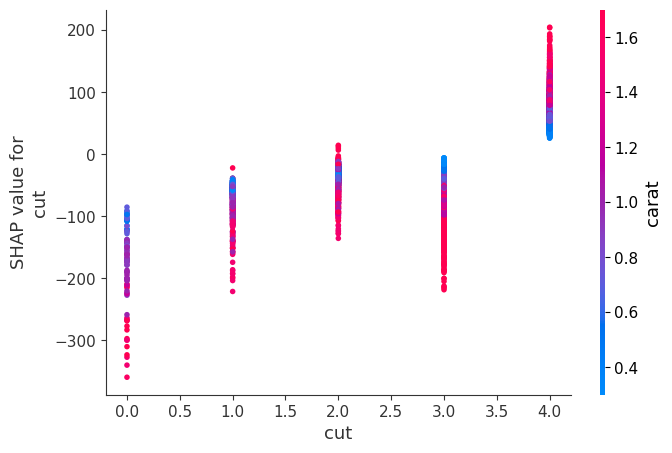

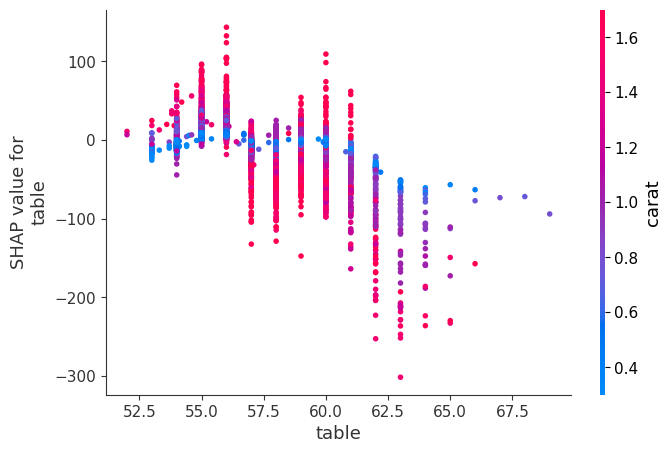

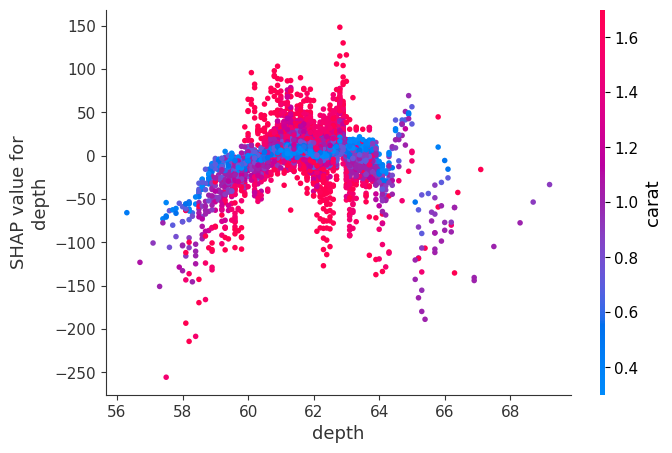

In [75]:
for col in ['y', 'carat', 'clarity', 'z', 'x', 'colour', 'cut', 'table', 'depth']:
    shap.dependence_plot(col, lgb_shap_vals.values, X_vals)

## Performance comparison

In summary, the scores for the linear model are:

**Training data**
| Metric | Baseline linear model | Outliers removed* | Feature selection |
| ------ | --------------------- | ----------------- | ----------------- |
| RMSE | 831.70 | 793.49 | 961.36 |
| R-squared | 0.9574 | 0.9611 | 0.9429 |
| MAE | 419.49 | 413.80 | 483.65 |
| Median AE | 164.93 | 165.47 | 181.67 |
| MAPE | 10.52 | 10.37 | 11.51 |

**Validation data**
| Metric | Baseline linear model | Outliers removed | Feature selection |
| ------ | --------------------- | ---------------- | ----------------- |
| RMSE | 817.93 | 804.54 | 968.66 |
| R-squared | 0.9592 | 0.9605 | 0.9427 |
| MAE | 425.32 | 421.15 | 490.01 |
| Median AE | 168.31 | 168.15 | 182.84 |
| MAPE | 10.47 | 10.40 | 11.53 |

* Outliers were only removed in the training data to simulate the situation in which predictions are desired for all "test" observations

In summary, the scores for the boosted tree model are:

**Training data**
| Metric | Baseline tree model   | Outliers removed* | Tuned on baseline | Tuned on outliers |
| ------ | --------------------- | ----------------- | ----------------- | ----------------- |
| RMSE | 555.00 | 555.39 | 543.52 | 543.97 |
| R-squared | 0.9810 | 0.9810 | 0.9818 | 0.9817 |
| MAE | 291.71 | 292.33 | 282.10 | 278.28 |
| Median AE | 124.82 | 124.64 | 117.89 | 113.07 |
| MAPE | 8.36 | 8.28 | 7.84 | 7.43 |

**Validation data**
| Metric | Baseline tree model | Outliers removed | Tuned on baseline | Tuned on outliers |
| ------ | ------------------- | ---------------- | ----------------- | ----------------- |
| RMSE | 574.13 | 575.15 | 578.39 | 582.63 |
| R-squared | 0.9799 | 0.9798 | 0.9796 | 0.9793 |
| MAE | 297.67 | 298.46 | 294.33 | 293.91 |
| Median AE | 126.87 | 126.48 | 121.46 | 117.95 |
| MAPE | 8.30 | 8.32 | 7.88 | 7.71 |

* Outliers were only removed in the training data to simulate the situation in which predictions are desired for all "test" observations

## Test Set Predictions

In [91]:
test_data = pd.read_csv('test.csv')
print(test_data.shape)
test_data.describe(include='all')

(129050, 10)


,id,carat,cut,color,clarity,depth,table,x,y,z
count,129050.000000,129050.000000,129050,129050,129050,129050.000000,129050.000000,129050.000000,129050.000000,129050.000000
unique,NaN,NaN,5,7,8,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ideal,G,SI1,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,61223,29561,35336,NaN,NaN,NaN,NaN,NaN
mean,258097.500000,0.789256,NaN,NaN,NaN,61.820522,57.239608,5.711767,5.716336,3.531802
std,37253.670457,0.462502,NaN,NaN,NaN,1.080249,1.918908,1.109666,1.102485,0.690749
min,193573.000000,0.200000,NaN,NaN,NaN,53.200000,51.000000,0.000000,0.000000,0.000000
25%,225835.250000,0.400000,NaN,NaN,NaN,61.300000,56.000000,4.700000,4.710000,2.900000
50%,258097.500000,0.700000,NaN,NaN,NaN,61.900000,57.000000,5.700000,5.720000,3.530000
75%,290359.750000,1.030000,NaN,NaN,NaN,62.400000,58.000000,6.510000,6.510000,4.030000


In [92]:
# encode the categorical variables
cut_dict = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_dict = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
colour_dict = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}

test_data['cut'] = test_data.cut.map(cut_dict)
test_data['clarity'] = test_data.clarity.map(clarity_dict)
test_data['colour'] = test_data.color.map(colour_dict)

X_test = test_data[['carat', 'cut', 'clarity', 'colour', 'depth', 'table', 'x', 'y', 'z']]

In [93]:
tuned_model

LGBMRegressor(colsample_bytree=0.6896509863428757,
              learning_rate=0.08936374828855384, max_depth=10,
              min_data_in_leaf=241, n_estimators=450, num_leaves=65,
              subsample=0.9945376037736102)

In [94]:
tuned_model2

LGBMRegressor(colsample_bytree=0.5248649910349452,
              learning_rate=0.018707915205378824, max_depth=12,
              min_data_in_leaf=201, n_estimators=700, num_leaves=2968,
              subsample=0.6127647838955468)

In [95]:
test_preds = tuned_model.predict(X_test)
test_preds2 = tuned_model2.predict(X_test)

In [103]:
submission = pd.DataFrame(test_data.id)
submission['price'] = test_preds
submission.to_csv('comp_submission.csv', index=False)

submission2 = pd.DataFrame(test_data.id)
submission2['price'] = test_preds2
submission2.to_csv('comp_submission2.csv', index=False)